In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
from euler_self_torch import euler_self_tlist

# Oscillator as neural ODE (no control yet)

In [3]:
# Define true ODE
class odeModel_oscillator(nn.Module):
    def __init__(self):
        self.A = torch.tensor([[0, 1],[-1, -0.1]])

    def forward(self, t, y):
        return torch.mm(y, self.A)

In [4]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0_free = torch.tensor([[5., 5.]])

# neural_ode = NeuralODE(odeModel_oscillator(), t=t_grid)
free_trajectory = euler_self_tlist(odeModel_oscillator(), y0_free, t_grid, 1e-2)
free_trajectory.shape

torch.Size([1000, 1, 2])

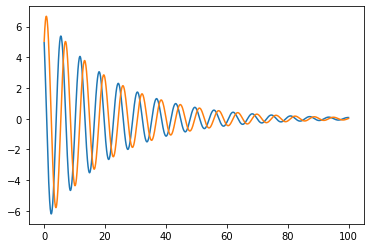

In [5]:
plt.plot(t_grid, free_trajectory[:,0,0], t_grid, free_trajectory[:,0,1])

# Oscillator with controller

In [6]:
# Define true ODE
class odeModel_oscillator_control(nn.Module):

    def __init__(self):
        super(odeModel_oscillator_control, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )
        
        self.A = torch.tensor([[0, 1],[-1, -0.1]])

#         for m in self.net.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

    def forward(self, t_grid, y):
        con = self.net(y)
        free = torch.mm(y, self.A)
        con = torch.cat([torch.zeros(con.shape),con], dim=1)
        dy = free + con
        return dy

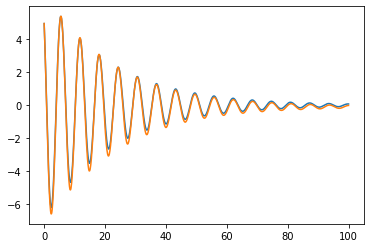

In [7]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0_free = torch.tensor([[5., 5.]])

# Run forward evaluation
trajectory = euler_self_tlist(odeModel_oscillator_control(), y0_free, t_grid, 1e-2)
free_trajectory = euler_self_tlist(odeModel_oscillator(), y0_free, t_grid, 1e-2)

plt.plot(t_grid, free_trajectory[:,0,0].detach().numpy(), t_grid, trajectory[:,0,0].detach().numpy())

# Train

In [8]:
# model = odeModel_oscillator_control()

# batch_y0 = get_batch()  # get random initial condition

# pred_y = euler_self_tlist(model, batch_y0, t_grid, 1e-1)  # solve forward
# loss = torch.mean(pred_y**2)
# loss.backward()  # performs backprop
# optimizer.step()

In [9]:
def get_batch(batch_size):
    return torch.rand(batch_size, 2).add_(-0.5).mul_(30)

Iter 0000 | Total Loss 1.384346


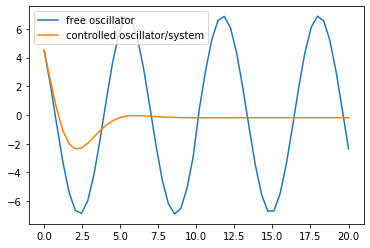

Iter 0020 | Total Loss 0.799806


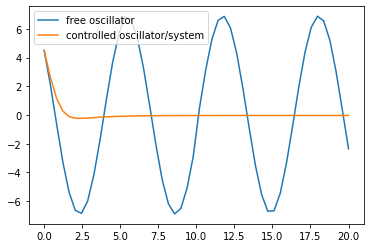

Iter 0040 | Total Loss 0.744538


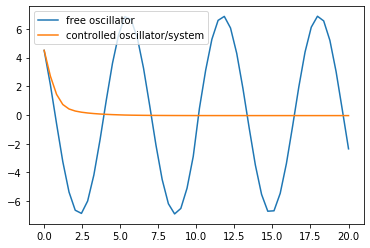

Iter 0060 | Total Loss 0.726545


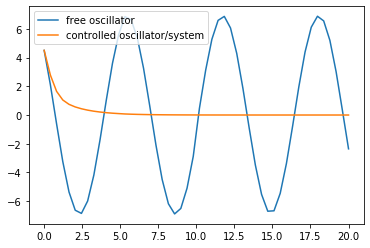

Iter 0080 | Total Loss 0.721489


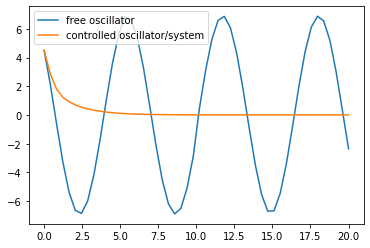

In [10]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 20, time_steps)

# Free system for comparison
free_trajectory = euler_self_tlist(odeModel_oscillator(), y0_free, t_grid, 1e-1)

# Initialise new instance of the model
model = odeModel_oscillator_control()
optimizer = optim.RMSprop(model.parameters(), lr=1e-2)


batch_size = 20
niters = 100
test_freq = 20
ii = 0
loss_history = []


# Run simulation niters times, updating parameters on each iteration
for itr in range(niters):
    optimizer.zero_grad()  # the gradients accumulate during backpropagation, so one needs to reset them for each batch
    batch_y0 = get_batch(batch_size)  # get random initial condition

    pred_y = euler_self_tlist(model, batch_y0, t_grid, 1e-1)  # solve forward
    loss = torch.mean(pred_y**2)
    loss.backward()  # performs backprop
    optimizer.step()  # performs an update step using the gradients computed in backward()
    
    loss_history.append(loss.item())    
    
    if itr % test_freq == 0:
#         with torch.no_grad():
            pred_y = euler_self_tlist(model, y0_free, t_grid, 1e-1)
            loss = torch.mean(pred_y**2)
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            
            plt.plot(t_grid, free_trajectory[:, 0, 0].detach().numpy(), t_grid, pred_y[:, 0, 0].detach().numpy())
            plt.legend( ('free oscillator', 'controlled oscillator/system'))
            plt.show()
        
            ii += 1

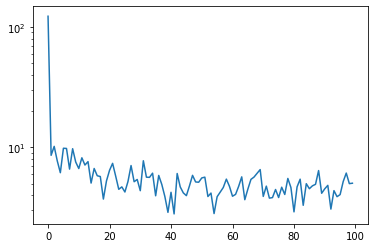

In [11]:
plt.plot(loss_history)
plt.yscale("log")